In [110]:
from ooipy.request.hydrophone_request import get_acoustic_data_LF
from datetime import datetime
from pathlib import Path
import soundfile as sf
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import gridspec
from typing import Optional
import pvlib
import matplotlib.dates as md

In [111]:
#node = 'AXEC2'
# node = 'HYSB1'
# node = 'AXBA1'
node = 'AXCC1'

In [126]:
starttime=datetime(2025,1,21,13)
endtime=datetime(2025,1,21,23, 59)

In [154]:
node_dict = {
    'AXEC2': 'RS03ECAL-MJ03E-09-HYDLFA304', 
    'HYSB1':'slope base', 
    'AXBA1':'Axial Base',
    'AXCC1': 'RS03CCAL-MJ03F-06-HYDLFA305' 
}

In [128]:
date_str = datetime.strftime(starttime, "%Y_%m_%d")
date_str

'2025_01_21'

In [129]:
LF_data = get_acoustic_data_LF(
    starttime=starttime,
    endtime=endtime,
    node=node,
    verbose=True,
)   

In [130]:
LF_data

OO.AXCC1.AXCC1.HDH | 2025-01-21T13:00:00.000000Z - 2025-01-21T23:59:00.000000Z | 200.0 Hz, 7908001 samples

In [131]:
LF_data.data

array([-27567, -27456, -27457, ..., -27535, -27557, -27535], dtype=int32)

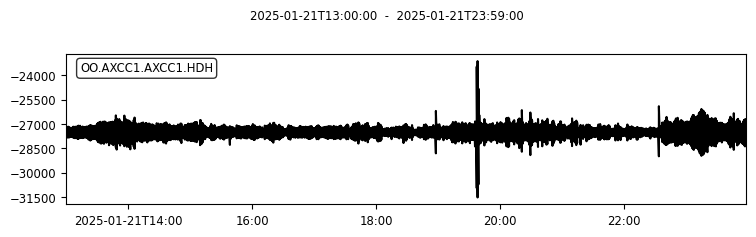

In [132]:
_ = LF_data.plot()

In [133]:
LF_data.stats

         network: OO
         station: AXCC1
        location: AXCC1
         channel: HDH
       starttime: 2025-01-21T13:00:00.000000Z
         endtime: 2025-01-21T23:59:00.000000Z
   sampling_rate: 200.0
           delta: 0.005
            npts: 7908001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 24703, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 12647936})

In [134]:
import obspy as obs

In [135]:
clean_data = LF_data.copy()

In [136]:
clean_data.data = (clean_data.data - np.mean(clean_data.data)) / np.max(np.abs(clean_data.data)) 

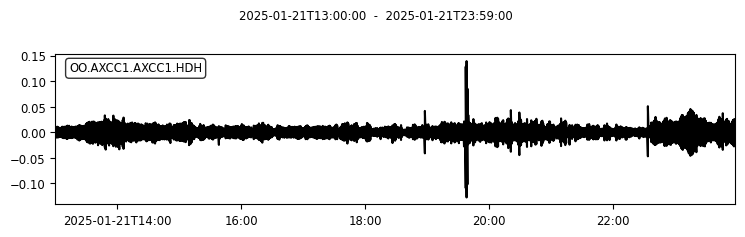

In [137]:
_ = clean_data.plot()

In [138]:
sf.write('WHALE_3.flac', clean_data.data, samplerate=200*20)

In [139]:
spec = LF_data.compute_spectrogram(L=2048, avg_time=20, verbose=True,)

In [140]:
spec

<xarray.DataArray 'spectrogram' (time: 1977, frequency: 1025)>
array([[65.65466061, 72.70750835, 76.1791526 , ..., 21.34859196,
        18.91751143, 18.77927582],
       [67.20036615, 63.7765907 , 71.90984564, ..., 11.53036896,
        10.25483926, 12.52746336],
       [66.3844305 , 76.98952079, 86.09712347, ..., 21.33080372,
        17.09526972, 15.39981523],
       ...,
       [66.44189945, 75.25552405, 77.08337944, ..., 16.3693347 ,
        20.10980418, 13.56737462],
       [61.35399403, 68.36080958, 76.66998805, ..., 21.31029041,
        21.56425198, 20.18503606],
       [57.86832617, 70.4709353 , 81.36044882, ..., 15.38222329,
        15.13662384, 11.39916573]])
Coordinates:
  * time       (time) datetime64[ns] 2025-01-21T13:00:00 ... 2025-01-21T23:58:40
  * frequency  (frequency) float64 0.0 0.09766 0.1953 0.293 ... 99.8 99.9 100.0
Attributes:
    start_time:  2025-01-21 13:00:00
    end_time:    2025-01-21 23:59:00
    nperseg:     2048
    units:       dB rel µ Pa^2 / Hz

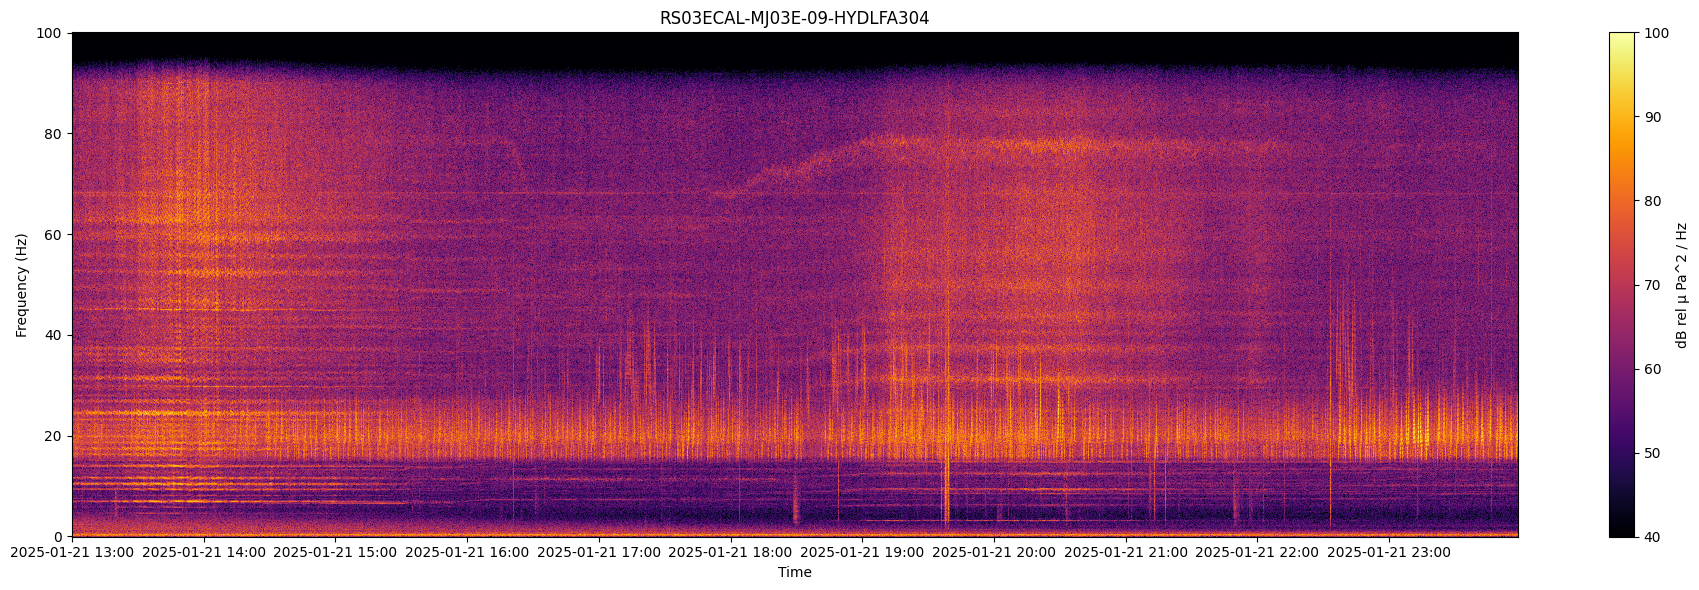

In [141]:
plt.figure(figsize=(19, 6))
pcm = plt.pcolormesh(
    spec['time'],
    spec['frequency'],
    spec.T,
    shading='nearest',
    vmin=40,
    vmax=100,
    cmap='inferno'
)
plt.colorbar(pcm, label=spec.attrs.get("units"))
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.title(refdes)

# Format time axis: mark every hour, keep date, and slant labels
ax = plt.gca()
ax.xaxis.set_major_locator(md.HourLocator(interval=1))  # Tick every hour
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d %H:%M'))  # Keep date + time

plt.tight_layout()
plt.show()

In [142]:
from typing import Final

DEFAULT_LAT_LON_FOR_SOLPOS: Final = (36.7128, -122.186)

DEFAULT_TITLE: Final = (
    "MBARI MARS Cabled Observatory   Monterey Bay, California, USA"
    f"   {DEFAULT_LAT_LON_FOR_SOLPOS[0]} °N, {DEFAULT_LAT_LON_FOR_SOLPOS[1]} °W"
)

DEFAULT_YLIM: Final = (10, 100000)

DEFAULT_CMLIM: Final = (32, 108)

DEFAULT_DPI: Final = 200

In [143]:
ds = spec.to_dataset(name='psd')

In [144]:
ds

<xarray.Dataset>
Dimensions:    (time: 1977, frequency: 1025)
Coordinates:
  * time       (time) datetime64[ns] 2025-01-21T13:00:00 ... 2025-01-21T23:58:40
  * frequency  (frequency) float64 0.0 0.09766 0.1953 0.293 ... 99.8 99.9 100.0
Data variables:
    psd        (time, frequency) float64 65.65 72.71 76.18 ... 15.38 15.14 11.4

In [145]:
ds.time

<xarray.DataArray 'time' (time: 1977)>
array(['2025-01-21T13:00:00.000000000', '2025-01-21T13:00:20.000000000',
       '2025-01-21T13:00:40.000000000', ..., '2025-01-21T23:58:00.000000000',
       '2025-01-21T23:58:20.000000000', '2025-01-21T23:58:40.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2025-01-21T13:00:00 ... 2025-01-21T23:58:40

In [146]:
ds

<xarray.Dataset>
Dimensions:    (time: 1977, frequency: 1025)
Coordinates:
  * time       (time) datetime64[ns] 2025-01-21T13:00:00 ... 2025-01-21T23:58:40
  * frequency  (frequency) float64 0.0 0.09766 0.1953 0.293 ... 99.8 99.9 100.0
Data variables:
    psd        (time, frequency) float64 65.65 72.71 76.18 ... 15.38 15.14 11.4

In [147]:
type(ds.time.data[0])

numpy.datetime64

In [155]:
def plot_dataset_summary(
    ds: xr.Dataset,
    lat_lon_for_solpos: tuple[float, float] = DEFAULT_LAT_LON_FOR_SOLPOS,
    title: str = DEFAULT_TITLE,
    ylim: tuple[int, int] = DEFAULT_YLIM,
    yscale: str = 'log',
    cmlim: tuple[int, int] = DEFAULT_CMLIM,
    dpi: int = DEFAULT_DPI,
    cmap: str = 'rainbow',
    jpeg_filename: Optional[str] = None,
    show: bool = False,
):  # pylint: disable=R0915  too-many-statements
    # Code by RYJO, with some typing/formatting/variable naming adjustments.
    """
    Generate a summary plot from the given dataset.
    :param ds: Dataset to plot.
    :param lat_lon_for_solpos: Lat/Lon for solar position calculation.
    :param title: Title for the plot.
    :param ylim: Limits for the y-axis.
    :param cmlim: Limits passed to pcolormesh.
    :param dpi: DPI to use for the plot.
    :param jpeg_filename: If given, filename to save the plot to.
    :param show: Whether to show the plot.
    """
    plt.rcParams["text.usetex"] = False
    plt.rcParams["axes.edgecolor"] = "black"

    # Transpose psd array for plotting
    da = xr.DataArray.transpose(ds.psd)

    # get solar elevation
    # Estimate the solar position with a specific SPA defined with the argument 'method'
    latitude, longitude = lat_lon_for_solpos
    solpos = pvlib.solarposition.get_solarposition(
        ds.time, latitude=latitude, longitude=longitude
    )
    se = solpos.elevation  # isolate solar elevation
    # map elevation to gray scale
    seg = 0 * se  # 0 covers nighttime (black)
    # day (white)
    d = np.squeeze(np.where(se > 0))
    seg.iloc[d] = 1
    # dusk / dawn (gray range)
    d = np.squeeze(np.where(np.logical_and(se <= 0, se >= -12)))
    seg.iloc[d] = 1 - abs(se.iloc[d] / max(abs(se.iloc[d])))
    # Get the indices of the min and max
    seg1 = pd.Series.to_numpy(solpos.elevation)
    minidx = np.squeeze(np.where(seg1 == min(seg1)))
    maxidx = np.squeeze(np.where(seg1 == max(seg1)))

    seg3 = np.tile(seg, (50, 1))

    # plotting variables

    psdlabl = (
        r"Spectrum level (dB re 1 $\mu$Pa$\mathregular{^{2}}$ Hz$\mathregular{^{-1}}$)"
    )
    freqlabl = "Frequency (Hz)"

    # define percentiles
    pctlev = np.array([1, 10, 25, 50, 75, 90, 99])
    # initialize output array
    pctls = np.empty((pctlev.size, ds.frequency.size))
    # get percentiles
    np.nanpercentile(ds.psd, pctlev, axis=0, out=pctls)

    # create a figure
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(12)
    spec = gridspec.GridSpec(
        ncols=2,
        nrows=2,
        width_ratios=[2.5, 1],
        wspace=0.02,
        height_ratios=[0.045, 0.95],
        hspace=0.09,
    )

    # Use more of the available plotting space
    plt.subplots_adjust(left=0.06, right=0.94, bottom=0.12, top=0.89)

    # Spectrogram
    ax0 = fig.add_subplot(spec[2])
    vmin, vmax = cmlim
    sg = plt.pcolormesh(
        ds.time, ds.frequency, da, shading="nearest", cmap=cmap, vmin=vmin, vmax=vmax
    )
    plt.yscale(yscale)
    plt.ylim(list(ylim))
    plt.ylabel(freqlabl)
    xl = ax0.get_xlim()
    ax0.set_xticks([])
    # plt.colorbar(location='left', shrink = 0.25, fraction = 0.05)

    # Percentile
    pplabels = ["L99", "L90", "L75", "L50", "L25", "L10", "L1"]
    ax1 = fig.add_subplot(spec[3])
    ax1.yaxis.tick_right()
    ax1.yaxis.set_label_position("right")
    plt.plot(pctls.T, ds.frequency, linewidth=1)
    plt.yscale(yscale)
    plt.ylim(list(ylim))
    plt.xlabel(psdlabl)
    plt.ylabel(freqlabl)
    plt.legend(loc="lower left", labels=pplabels)

    # day night
    ax3 = fig.add_subplot(spec[0])
    ax3.pcolormesh(seg3, shading="flat", cmap="gray")
    ax3.annotate("Day", (maxidx, 25), weight="bold", ha="center", va="center")
    ax3.annotate(
        "Night", (minidx, 25), weight="bold", color="white", ha="center", va="center"
    )
    ax3.set_xticks([])
    ax3.set_yticks([])

    # colorbar for spectrogram
    r = np.concatenate(np.squeeze(ax0.get_position()))
    cb_ax = fig.add_axes([r[0] + 0.09, r[1] - 0.025, r[2] - 0.25, 0.015])
    q = fig.colorbar(sg, orientation="horizontal", cax=cb_ax)
    q.set_label(psdlabl)

    # time axes for the day/night panel
    # create a dummy time / zero range variable
    timax = fig.add_axes(ax3.get_position(), frameon=False)
    timax.plot(solpos.elevation * 0, "k")
    timax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    timax.set_ylim(0, 100)
    timax.set_yticks([])
    timax.set_xlim(xl)
    timax.xaxis.set_major_formatter(
        md.ConciseDateFormatter(timax.xaxis.get_major_locator())
    )

    plt.gcf().text(0.5, 0.955, title, fontsize=14, horizontalalignment="center")
    plt.gcf().text(0.65, 0.91, "UTC")

    if jpeg_filename is not None:
        plt.savefig(jpeg_filename, dpi=dpi)
    if show:
        plt.show()
    plt.close(fig)


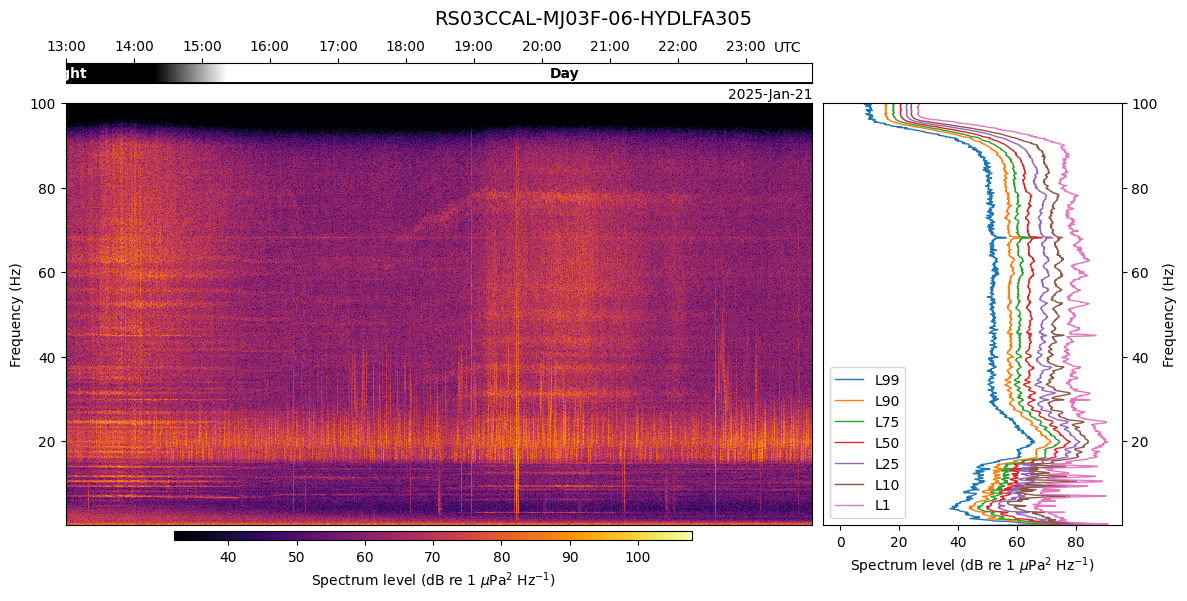

In [156]:
plot_dataset_summary(
    ds,
    title=node_dict[node],
    ylim=(0.1,100),
    jpeg_filename='./output/LF_spec.png',
    show=True,
    cmap='inferno',
    yscale='linear',
)